# Setup

In [1]:

import os
os.environ["FIG_DIR"] = "/teamspace/studios/this_studio/pyprobml/notebooks/figures"
#s.environ["DUAL_SAVE"] = "1"
#os.environ.pop("DUAL_SAVE", None)


In [2]:
#https://nipunbatra.github.io/blog/posts/2014-06-02-latexify.html
#https://github.com/probml/probml-utils/blob/main/probml_utils/plotting.py
#os.environ["LATEXIFY"] = "1"

import matplotlib.pyplot as plt

DEFAULT_WIDTH = 6.0
DEFAULT_HEIGHT = 1.5
SIZE_SMALL = 9  # Caption size in the pml book

def my_latexify(
    width_scale_factor=1,
    height_scale_factor=1,
    fig_width=None,
    fig_height=None,
    font_size=SIZE_SMALL,
):
    f"""
    width_scale_factor: float, DEFAULT_WIDTH will be divided by this number, DEFAULT_WIDTH is page width: {DEFAULT_WIDTH} inches.
    height_scale_factor: float, DEFAULT_HEIGHT will be divided by this number, DEFAULT_HEIGHT is {DEFAULT_HEIGHT} inches.
    fig_width: float, width of the figure in inches (if this is specified, width_scale_factor is ignored)
    fig_height: float, height of the figure in inches (if this is specified, height_scale_factor is ignored)
    font_size: float, font size
    """
    if fig_width is None:
        fig_width = DEFAULT_WIDTH / width_scale_factor
    if fig_height is None:
        fig_height = DEFAULT_HEIGHT / height_scale_factor

    # use TrueType fonts so they are embedded
    # https://stackoverflow.com/questions/9054884/how-to-embed-fonts-in-pdfs-produced-by-matplotlib
    # https://jdhao.github.io/2018/01/18/mpl-plotting-notes-201801/
    plt.rcParams["pdf.fonttype"] = 42

    # Font sizes
    # SIZE_MEDIUM = 14
    # SIZE_LARGE = 24
    # https://stackoverflow.com/a/39566040

    #plt.rcParams.update({
    #'font.size': 12,
    #})
    plt.rc("font", size=font_size)  # controls default text sizes
    plt.rc("axes", titlesize=font_size)  # fontsize of the axes title
    plt.rc("axes", labelsize=font_size)  # fontsize of the x and y labels
    plt.rc("xtick", labelsize=font_size)  # fontsize of the tick labels
    plt.rc("ytick", labelsize=font_size)  # fontsize of the tick labels
    plt.rc("legend", fontsize=font_size)  # legend fontsize
    plt.rc("figure", titlesize=font_size)  # fontsize of the figure title
    plt.rc("lines", linewidth=2)

    #plt.rcParams["backend"] = "ps"
    #plt.rc("text", usetex=True)
    plt.rc("font", family="serif")
    plt.rc("figure", figsize=(fig_width, fig_height))

my_latexify(fig_width=4.5, fig_height=3)

In [3]:
# good aspect ratios
target=[4.0/3, 16.0/9 ]
print(target)
vals = [6.0/4, 7.0/4, 3.5/2]
print(vals)

[1.3333333333333333, 1.7777777777777777]
[1.5, 1.75, 1.75]


In [4]:
#https://nipunbatra.github.io/blog/posts/2014-06-02-latexify.html
#os.environ["LATEXIFY"] = "1"
#os.environ.pop('LATEXIFY', None)
#pml.latexify()

os.environ.pop("DUAL_SAVE", None)

my_latexify(fig_width=3.5, fig_height=2)
#my_latexify(width_scale_factor=2, fig_height=2)

In [5]:
# Plot polynomial regression on 1d problem
# Based on https://github.com/probml/pmtk3/blob/master/demos/linregPolyVsDegree.m


import numpy as np
import matplotlib.pyplot as plt
import os

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

try:
    from sklearn.preprocessing import PolynomialFeatures
except ModuleNotFoundError:
    %pip install -qq scikit-learn
    from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics
from sklearn.metrics import mean_squared_error as mse


def make_1dregression_data(n=21, m=20):
    np.random.seed(0)
    xtrain = np.linspace(0.0, 20, n)
    #https://github.com/probml/pml-book/issues/611
    xtest = np.arange(0.0, m, 0.1)
    #xtest = np.arange(0.0, 21, 0.1)
    sigma2 = 4
    w = np.array([-1.5, 1 / 9.0])
    fun = lambda x: w[0] * x + w[1] * np.square(x)
    ytrain = fun(xtrain) + np.random.normal(0, 1, xtrain.shape) * np.sqrt(sigma2)
    ytest = fun(xtest) + np.random.normal(0, 1, xtest.shape) * np.sqrt(sigma2)
    return xtrain, ytrain, xtest, ytest


xtrain, ytrain, xtest, ytest = make_1dregression_data(n=21)

# Rescaling data
scaler = MinMaxScaler(feature_range=(-1, 1))
Xtrain = scaler.fit_transform(xtrain.reshape(-1, 1))
Xtest = scaler.transform(xtest.reshape(-1, 1))


degs = np.arange(1, 21, 1)
ndegs = np.max(degs)
mse_train = np.empty(ndegs)
mse_test = np.empty(ndegs)
ytest_pred_stored = np.empty(ndegs, dtype=np.ndarray)
ytrain_pred_stored = np.empty(ndegs, dtype=np.ndarray)
for deg in degs:
    model = LinearRegression()
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    Xtrain_poly = poly_features.fit_transform(Xtrain)
    model.fit(Xtrain_poly, ytrain)
    ytrain_pred = model.predict(Xtrain_poly)
    ytrain_pred_stored[deg - 1] = ytrain_pred
    Xtest_poly = poly_features.transform(Xtest)
    ytest_pred = model.predict(Xtest_poly)
    mse_train[deg - 1] = mse(ytrain_pred, ytrain)
    mse_test[deg - 1] = mse(ytest_pred, ytest)
    ytest_pred_stored[deg - 1] = ytest_pred




# MSE vs degree

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/probml_utils/plotting.py:70: UserWarning: renaming /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitVsDegree.pdf to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitVsDegree.pdf because LATEXIFY is False
  warnings.warn(


saving image to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitVsDegree.pdf
Figure size: [3.5 2. ]


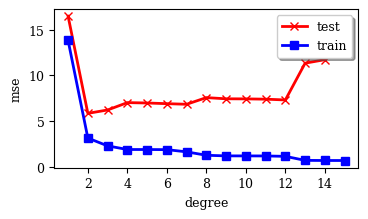

In [6]:
# Plot MSE vs degree

fig, ax = plt.subplots()
mask = degs <= 15
ax.plot(degs[mask], mse_test[mask], color="r", marker="x", label="test")
ax.plot(degs[mask], mse_train[mask], color="b", marker="s", label="train")
ax.legend(loc="upper right", shadow=True)
plt.xlabel("degree")
plt.ylabel("mse")
pml.savefig("polyfitVsDegree.pdf")
plt.show()


# Plot fitted functions

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/probml_utils/plotting.py:70: UserWarning: renaming /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree1.pdf to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree1.pdf because LATEXIFY is False
  warnings.warn(


saving image to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree1.pdf
Figure size: [3.5 2. ]


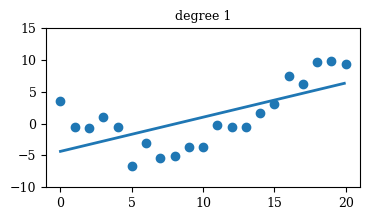

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/probml_utils/plotting.py:70: UserWarning: renaming /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree2.pdf to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree2.pdf because LATEXIFY is False
  warnings.warn(


saving image to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree2.pdf
Figure size: [3.5 2. ]


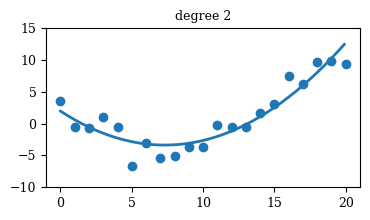

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/probml_utils/plotting.py:70: UserWarning: renaming /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree3.pdf to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree3.pdf because LATEXIFY is False
  warnings.warn(


saving image to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree3.pdf
Figure size: [3.5 2. ]


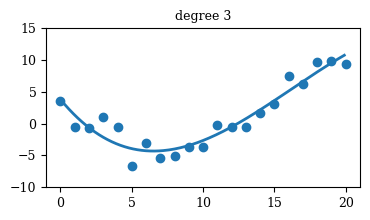

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/probml_utils/plotting.py:70: UserWarning: renaming /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree14.pdf to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree14.pdf because LATEXIFY is False
  warnings.warn(


saving image to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree14.pdf
Figure size: [3.5 2. ]


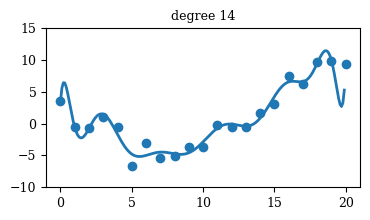

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/probml_utils/plotting.py:70: UserWarning: renaming /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree20.pdf to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree20.pdf because LATEXIFY is False
  warnings.warn(


saving image to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree20.pdf
Figure size: [3.5 2. ]


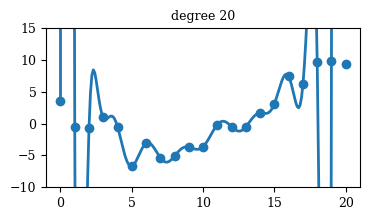

In [7]:

# Plot fitted functions
chosen_degs = [1, 2, 3, 14, 20]

for deg in chosen_degs:
    fig, ax = plt.subplots() #figsize=(15, 15))
    ax.scatter(xtrain, ytrain)
    ax.plot(xtest, ytest_pred_stored[deg - 1])
    ax.set_ylim((-10, 15))
    plt.title("degree {}".format(deg))
    pml.savefig("polyfitDegree{}.pdf".format(deg))
    plt.show()

# Plot residuals

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/probml_utils/plotting.py:70: UserWarning: renaming /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree1Residuals.pdf to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree1Residuals.pdf because LATEXIFY is False
  warnings.warn(


saving image to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree1Residuals.pdf
Figure size: [3.5 2. ]


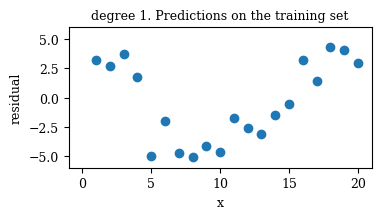

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/probml_utils/plotting.py:70: UserWarning: renaming /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree2Residuals.pdf to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree2Residuals.pdf because LATEXIFY is False
  warnings.warn(


saving image to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree2Residuals.pdf
Figure size: [3.5 2. ]


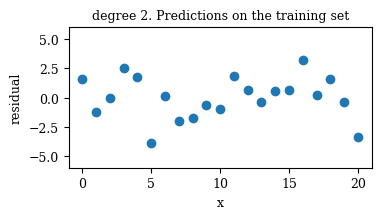

In [8]:

chosen_degs = [1,2]
# Plot residuals
for deg in chosen_degs:
    fig, ax = plt.subplots()
    ypred = ytrain_pred_stored[deg - 1]
    residuals = ytrain - ypred
    # ax.plot(ypred, residuals, 'o')
    # ax.set_xlabel('predicted y')
    ax.plot(xtrain, residuals, "o")
    ax.set_xlabel("x")
    ax.set_ylabel("residual")
    ax.set_ylim(-6, 6)
    plt.title("degree {}. Predictions on the training set".format(deg))
    pml.savefig("polyfitDegree{}Residuals.pdf".format(deg))
    plt.show()


# Plot fit vs actual

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/probml_utils/plotting.py:70: UserWarning: renaming /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree1FitVsActualTrain.pdf to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree1FitVsActualTrain.pdf because LATEXIFY is False
  warnings.warn(


saving image to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree1FitVsActualTrain.pdf
Figure size: [3.5 2. ]


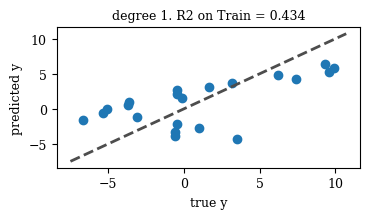

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/probml_utils/plotting.py:70: UserWarning: renaming /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree1FitVsActualTest.pdf to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree1FitVsActualTest.pdf because LATEXIFY is False
  warnings.warn(


saving image to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree1FitVsActualTest.pdf
Figure size: [3.5 2. ]


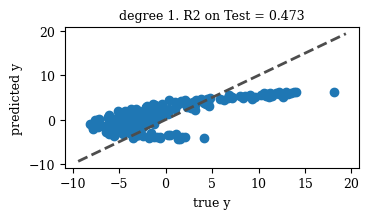

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/probml_utils/plotting.py:70: UserWarning: renaming /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree2FitVsActualTrain.pdf to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree2FitVsActualTrain.pdf because LATEXIFY is False
  warnings.warn(


saving image to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree2FitVsActualTrain.pdf
Figure size: [3.5 2. ]


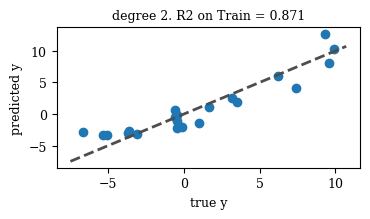

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/probml_utils/plotting.py:70: UserWarning: renaming /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree2FitVsActualTest.pdf to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree2FitVsActualTest.pdf because LATEXIFY is False
  warnings.warn(


saving image to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree2FitVsActualTest.pdf
Figure size: [3.5 2. ]


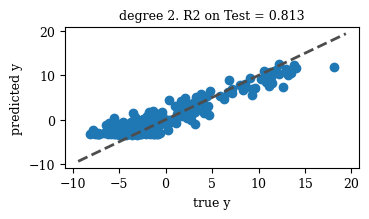

In [9]:

# Plot fit vs actual
for deg in chosen_degs:
    for train in [True, False]:
        if train:
            ytrue = ytrain
            ypred = ytrain_pred_stored[deg - 1]
            dataset = "Train"
        else:
            ytrue = ytest
            ypred = ytest_pred_stored[deg - 1]
            dataset = "Test"
        fig, ax = plt.subplots()
        ax.scatter(ytrue, ypred)
        # https://github.com/probml/pml-book/issues/620
        #ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
        ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3")

        ax.set_xlabel("true y")
        ax.set_ylabel("predicted y")
        r2 = sklearn.metrics.r2_score(ytrue, ypred)
        plt.title("degree {}. R2 on {} = {:0.3f}".format(deg, dataset, r2))
        pml.savefig("polyfitDegree{}FitVsActual{}.pdf".format(deg, dataset))
        plt.show()

# Replot fitted functions using larger x range (to show interpolation)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/probml_utils/plotting.py:70: UserWarning: renaming /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree2_range21.pdf to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree2_range21.pdf because LATEXIFY is False
  warnings.warn(


saving image to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree2_range21.pdf
Figure size: [3.5 2. ]


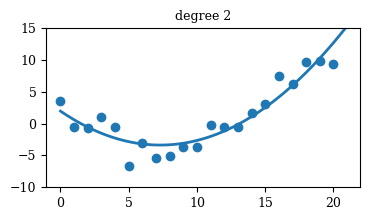

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/probml_utils/plotting.py:70: UserWarning: renaming /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree14_range21.pdf to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree14_range21.pdf because LATEXIFY is False
  warnings.warn(


saving image to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree14_range21.pdf
Figure size: [3.5 2. ]


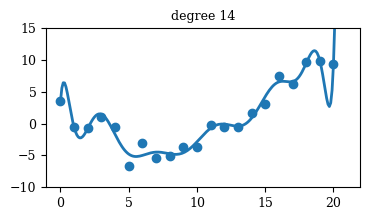

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/probml_utils/plotting.py:70: UserWarning: renaming /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree20_range21.pdf to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree20_range21.pdf because LATEXIFY is False
  warnings.warn(


saving image to /teamspace/studios/this_studio/pyprobml/notebooks/figures/polyfitDegree20_range21.pdf
Figure size: [3.5 2. ]


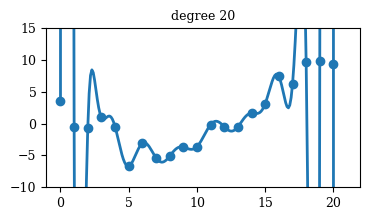

In [10]:

# Response to https://github.com/probml/pml-book/issues/611
# Now replot fitted functions for xtest = 0 to 21 so D=20 interpolates all points
# (This messes up the mse vs degree plot, so we don't recompute that)




xtrain, ytrain, xtest, ytest = make_1dregression_data(n=21, m=21)

# Rescaling data
scaler = MinMaxScaler(feature_range=(-1, 1))
Xtrain = scaler.fit_transform(xtrain.reshape(-1, 1))
Xtest = scaler.transform(xtest.reshape(-1, 1))


degs = np.arange(1, 21, 1)
ndegs = np.max(degs)
mse_train = np.empty(ndegs)
mse_test = np.empty(ndegs)
ytest_pred_stored = np.empty(ndegs, dtype=np.ndarray)
ytrain_pred_stored = np.empty(ndegs, dtype=np.ndarray)
for deg in degs:
    model = LinearRegression()
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    Xtrain_poly = poly_features.fit_transform(Xtrain)
    model.fit(Xtrain_poly, ytrain)
    ytrain_pred = model.predict(Xtrain_poly)
    ytrain_pred_stored[deg - 1] = ytrain_pred
    Xtest_poly = poly_features.transform(Xtest)
    ytest_pred = model.predict(Xtest_poly)
    mse_train[deg - 1] = mse(ytrain_pred, ytrain)
    mse_test[deg - 1] = mse(ytest_pred, ytest)
    ytest_pred_stored[deg - 1] = ytest_pred

# Plot fitted functions
chosen_degs = [2, 14, 20]

for deg in chosen_degs:
    fig, ax = plt.subplots() #figsize=(15, 15))
    ax.scatter(xtrain, ytrain)
    ax.plot(xtest, ytest_pred_stored[deg - 1])
    ax.set_ylim((-10, 15))
    plt.title("degree {}".format(deg))
    pml.savefig("polyfitDegree{}_range21.pdf".format(deg))
    plt.show()